# **Notebook Overview: Pneumonia Detection Using InceptionV3**

#### This notebook is designed to develop, train, and evaluate a deep learning model using the **InceptionV3** architecture for the detection of pneumonia from chest X-ray images. Below is a detailed description of each section and the purpose it serves.

### 1. Importing Libraries and Packages

In [7]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

#### Purpose: Importing essential libraries for data manipulation, visualization, image processing, and deep learning.

### 2. Setting Hyperparameters and Data Paths

In [8]:
EPOCHS = 30
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

#### Purpose: Setting the number of training epochs and defining the directory paths for training, validation, and test datasets.

### 3. Data Transformation Function

In [9]:
# Define a function for data transformations
def data_transforms(phase):
    # If the phase is TRAIN
    if phase == TRAIN:
        # Compose transformations: Resize, CenterCrop, Convert to Tensor, Normalize
        transform = transforms.Compose([
            transforms.Resize(299),  # Resize the image to 256x256 pixels
             transforms.CenterCrop(299),
            transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the Tensor
        ])
        
    # If the phase is VAL
    if phase == VAL:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    # If the phase is TEST
    if phase == TEST:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform  # Return the composed transformations

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

cuda:0


#### Purpose: Defining transformations for the images such as resizing, cropping, converting to tensor, and normalization. These are applied to the training, validation, and test datasets.

### 4. Preparing Data Loaders

In [10]:
# Create a dictionary of datasets for each phase (TRAIN, VAL, TEST)
# For each phase, load the images from the corresponding folder and apply the data transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}

# Create a dictionary of dataloaders for each phase
# For each phase, create a DataLoader that loads the data from the corresponding dataset
# The batch size and shuffle parameters can be adjusted as needed
dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True), 
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)
}

In [11]:
len(dataloaders[TRAIN])

1304

In [12]:
# Get the sizes of the datasets
dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in [TRAIN, VAL]
}

# Get the classes from the training dataset
classes = image_datasets[TRAIN].classes

# Get the class names from the training dataset
class_names = image_datasets[TRAIN].classes

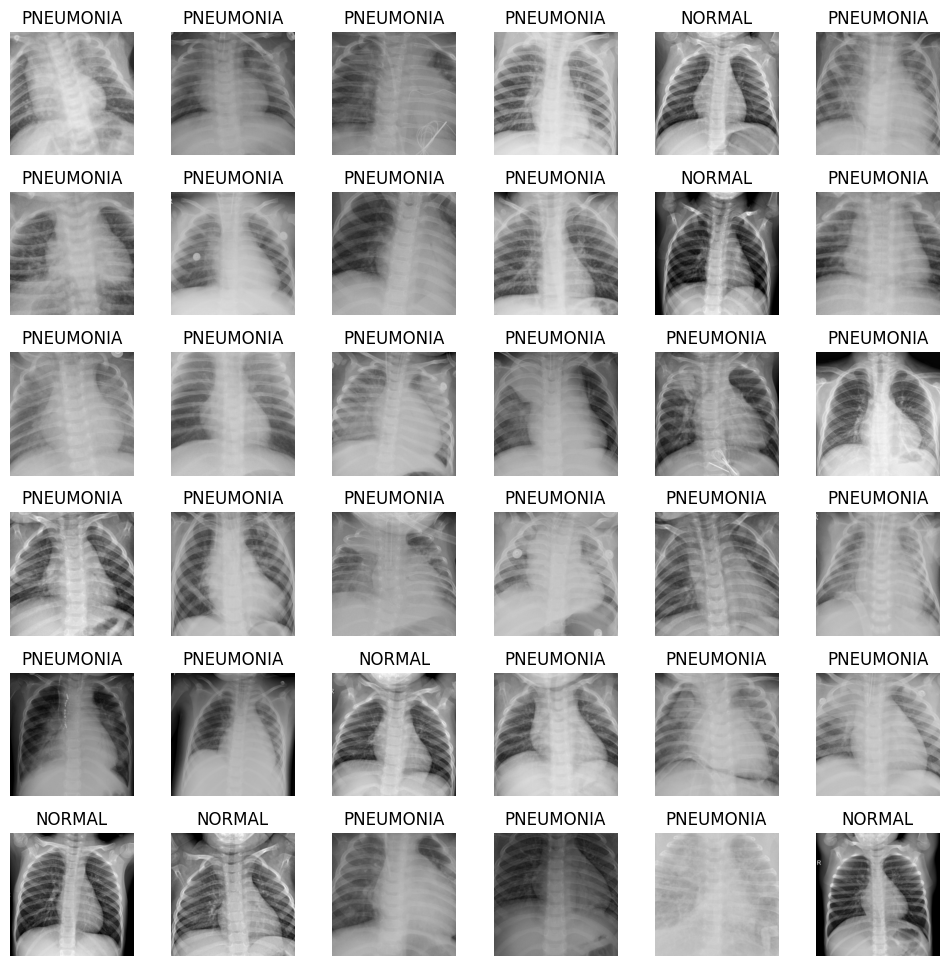

In [13]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [14]:
inputs, classes = next(iter(dataloaders[TRAIN]))

### 5. Training the Model

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # Save the initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        # Each epoch has a training and validation phase
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if we have a new best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights and return the model
    model.load_state_dict(best_model_wts)
    return model

In [18]:
model_pre = models.inception_v3()
model_pre.load_state_dict(torch.load("/kaggle/input/pytorch-pretrained-models/inception_v3_google-1a9a5a14.pth"))

<All keys matched successfully>

In [19]:
for param in model_pre.parameters():
    param.requires_grad = False   
    
model_pre.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model_pre.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,6))
model_pre.aux_logits = False

In [20]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.4480 Acc: 0.8006
val Loss: 0.5705 Acc: 0.6875
Epoch: 2/30
train Loss: 0.3557 Acc: 0.8505
val Loss: 0.7260 Acc: 0.6250
Epoch: 3/30
train Loss: 0.3360 Acc: 0.8583
val Loss: 0.6318 Acc: 0.6250
Epoch: 4/30
train Loss: 0.3419 Acc: 0.8554
val Loss: 0.5487 Acc: 0.6875
Epoch: 5/30
train Loss: 0.3262 Acc: 0.8614
val Loss: 0.7545 Acc: 0.5625
Epoch: 6/30
train Loss: 0.3140 Acc: 0.8689
val Loss: 0.4731 Acc: 0.7500
Epoch: 7/30
train Loss: 0.3231 Acc: 0.8635
val Loss: 1.2643 Acc: 0.5000
Epoch: 8/30
train Loss: 0.3105 Acc: 0.8710
val Loss: 0.5389 Acc: 0.7500
Epoch: 9/30
train Loss: 0.3202 Acc: 0.8641
val Loss: 0.7388 Acc: 0.5625
Epoch: 10/30
train Loss: 0.3139 Acc: 0.8731
val Loss: 0.7261 Acc: 0.6250
Epoch: 11/30
train Loss: 0.3098 Acc: 0.8708
val Loss: 0.7581 Acc: 0.5625
Epoch: 12/30
train Loss: 0.2804 Acc: 0.8808
val Loss: 0.6079 Acc: 0.6875
Epoch: 13/30
train Loss: 0.3030 Acc: 0.8756
val Loss: 0.6894 Acc: 0.6250
Epoch: 14/30
train Loss: 0.2927 Acc: 0.8798
val Loss: 0.7804 Acc: 0.5625

In [22]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.append(labels.item())
            
            #Store model input images
            input_images.append(inputs)
            
            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [23]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

### 6. Visualizing Predictions

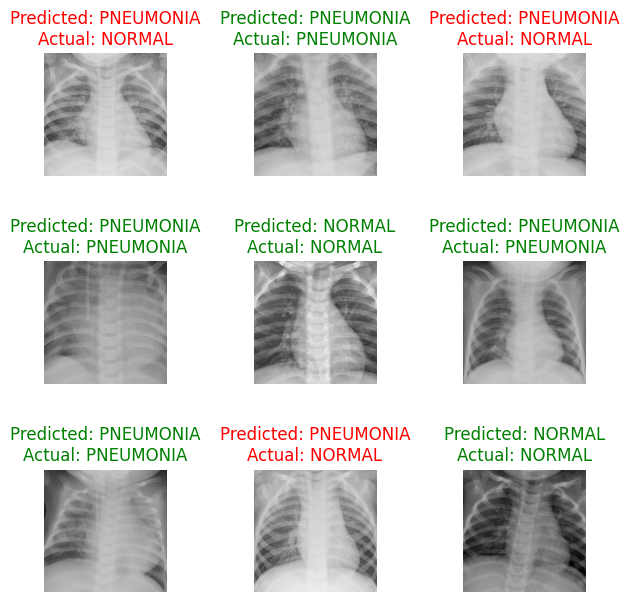

In [24]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        inp = input_images[x].squeeze()
      
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()

### 7. Printing Summary of Results

In [25]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 515.0 
Total Test Images: 624.0
Test Accuracy:  0.8253205128205128


#### Purpose: Displaying the total number of correct predictions and the overall test accuracy.